# Reacher

---

In this notebook, we will train DDPG agent to navigate robotic manipulator to goal destination.

### 1. Start the Environment

We begin by importing some necessary packages and srarting Unity environment.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed necessary packages.

In [1]:
from unityagents import UnityEnvironment
from collections import deque

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import utils.config 
import pprint
import torch


env = UnityEnvironment(file_name='Reacher_Linux/Reacher.x86')

# Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Create instance of agent

Agent's hyperparameters are saved and loaded from config.py file in utils folder. Current values are result of selected after hyperparameter tuing. But you can try different hyperparameter values if you want.  

If you just want to see the trained agent jump to cell 5.

In [2]:
from agents.ddpg_agent import DDPG

# Load parameters from file
hparams = utils.config.HYPERPARAMS['DDPG']
params = utils.config.TRAINPARAMS['Reacher']

# Create agent instance
agent = DDPG(hparams)
print("Created agent with following hyperparameter values:")
pprint.pprint(hparams)

Created agent with following hyperparameter values:
{'action_size': 4,
 'batch_size': 128,
 'buffer_size': 100000,
 'fc1_units': 256,
 'fc2_units': 128,
 'gamma': 0.99,
 'lr_actor': 0.0001,
 'lr_critic': 0.0001,
 'name': 'DDPG',
 'random_seed': 0,
 'state_size': 33,
 'tau': 0.001,
 'weight_decay': 0.0001}


### 3. Train an egent!

In [3]:
# Reset and set environment to training mode
env_info = env.reset(train_mode=True)[brain_name]

# Maximum number of training episodes
n_episodes = params['n_episodes']
# Initialize epsilon
#epsilon = params['epsilon_start']
# List containing scores from each episode
scores = []
# Store last 100 scores
scores_window = deque(maxlen=params['scores_window_size'])

#states = env_info.vector_observations                  # get the current state (for each agent)
#scores = np.zeros(num_agents)                          # initialize the score (for each agent)

# Filename string
filename = "{:s}_lra{:.0E}_lrc{:.0E}_batch{:d}_fc:{:d}:{:d}_solved{:d}"

# Train loop
for i_episode in range(1, n_episodes+1):
    # Reset environment
    env_info = env.reset(train_mode=True)[brain_name]

    # Observe current state
    state = env_info.vector_observations[0]

    # Reset score and done flag
    score = 0
    done = False

    # Loop each episode
    while not done:

        # Select action with e-greedy policy
        action = agent.act(state)

        # Take action
        env_info = env.step(action)[brain_name]

        # Observe the next state
        next_state = env_info.vector_observations[0]

        # Get the reward
        reward = env_info.rewards[0]

        # Check if episode is finished
        done = env_info.local_done[0]

        # Store experience
        agent.step(state, action, reward, next_state, done)

        # State transition
        state = next_state

        # Update total score
        score += reward

    # Save most recent score
    scores_window.append(score)
    scores.append([score, np.mean(scores_window)])

    # Decay epsilon
    #epsilon = max(params['epsilon_final'], params['epsilon_decay']*epsilon)

    # Print learning progress
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    if i_episode % params['scores_window_size'] == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    if np.mean(scores_window)>=params['solve_score']:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
        filename = filename.format(hparams['name'], hparams['lr_actor'], hparams['lr_critic'], hparams['batch_size'],
                                   hparams['fc1_units'], hparams['fc2_units'], i_episode-100)
        torch.save(agent.actor_local.state_dict(), 'models/{:s}_actor.pth'.format(filename))
        torch.save(agent.critic_local.state_dict(), 'models/{:s}_critic.pth'.format(filename))
        break


Episode 100	Average Score: 9.07
Episode 182	Average Score: 30.08
Environment solved in 82 episodes!	Average Score: 30.08


### 4. Plot and save the score!

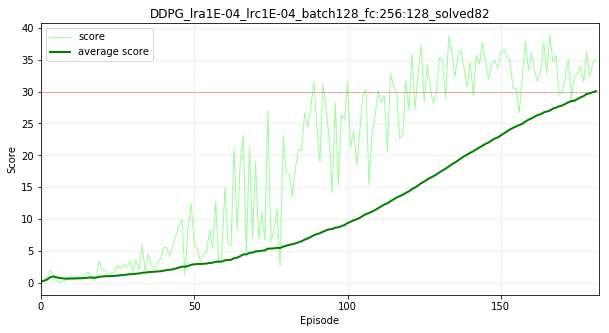

In [4]:
# Save score
df = pd.DataFrame(scores,columns=['scores','average_scores'])
df.to_csv('scores/{:s}.csv'.format(filename))

# Plot scores
plt.figure(figsize=(10,5))
plt.axhline(30, color='red', lw=1, alpha=0.3)
plt.plot( df.index, 'scores', data=df, color='lime', lw=1, label="score", alpha=0.4)
plt.plot( df.index, 'average_scores', data=df, color='green', lw=2, label="average score")
# Set labels and legends
plt.xlabel('Episode')
plt.xlim(0, len(df.index))
plt.xticks(50*np.arange(int(len(df.index)/50+1)))
plt.ylabel('Score')
#plt.yticks(3*np.arange(8))
plt.title(filename)
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend()
# Save figure
plt.savefig('docs/plots/{:s}.png'.format(filename), bbox_inches='tight')
plt.show()

When finished, close the environment.

### 5. Watch smart agent
If you are skipped training, please specify filename for pre-trained network model.

In [5]:
# Speed (False: Real time, True: Fast)
train_mode = False

# reset the environment
env_info = env.reset(train_mode=train_mode)[brain_name]

# Load learned model weight. Load 'DDPG_lra1E-04_lrc1E-04_batch128_fc:256:128_solved256' for optimal model
#filename = 'DDPG_lra1E-04_lrc1E-04_batch128_fc:256:128_solved256'
agent.actor_local.load_state_dict(torch.load('models/{}_actor.pth'.format(filename)))
agent.critic_local.load_state_dict(torch.load('models/{}_critic.pth'.format(filename)))

# Number of episodes to run
n_episodes = 1

# Run loop
for i_episode in range(1, n_episodes+1):
    # Reset environment
    env_info = env.reset(train_mode=train_mode)[brain_name]

    # Observe current state
    state = env_info.vector_observations[0]

    # Reset score and done flag
    score = 0
    done = False

    # Episode loop
    while not done:

        # Select action with greedy policy
        action = agent.act(state)

        # Take action
        env_info = env.step(action)[brain_name]

        # Observe the next state
        next_state = env_info.vector_observations[0]

        # Get the reward
        reward = env_info.rewards[0]

        # Check if episode is finished
        done = env_info.local_done[0]

        # State transition
        state = next_state

        # Update total score
        score += reward

    # Print episode summary
    print('Episode %d Score:%d'%(i_episode, score))

Episode 1 Score:37


In [6]:
env.close()